# Bias detection and mitigation in AutoAI

This notebook contains the steps and code to demonstrate support of AutoAI experiments with bias detection/mitigation in Watson Machine Learning service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:

-  Work with Watson Machine Learning experiments to train AutoAI models.
-  Compare trained models quality and select the best one for further refinement.
-  Investigate models fairness.
-  Online deployment and score the trained model.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Optimizer definition](#definition)
3. [Experiment with bias detection run](#run)
3. [Experiment with bias mitigation run](#run_mit)
5. [Deploy and Score](#scoring)
6. [Clean up](#cleanup)
7. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install "scikit-learn==1.3.0" | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U 'lale[fairness]' | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [2]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [4]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.0"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.0"
)

```

In [5]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [8]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [9]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## Optimizer definition

### Training data connection

This example uses the German Credit Risk dataset. 

The dataset can be downloaded from [here](https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv).

In [10]:
filename = 'german_credit_data_biased_training.csv'

Download training data from git repository and create data assets.

In [11]:
import wget
import os

url = "https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd5.0/data/bias/german_credit_data_biased_training.csv"
if not os.path.isfile(filename): 
    wget.download(url)
    
asset_details = client.data_assets.create(name=filename, file_path=filename)

Creating data asset...
SUCCESS


In [12]:
from ibm_watsonx_ai.helpers import DataConnection, AssetLocation

credit_risk_conn = DataConnection(
    location=AssetLocation(asset_id=client.data_assets.get_id(asset_details))
)

training_data_reference=[credit_risk_conn]

In [13]:
import pandas as pd

pd.read_csv(filename).head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


### Bias detection: optimizer configuration

Provide input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

Define `fairness_info`:

 - protected_attribute_names (array of items : string) – Subset of feature names for which fairness is desired.

 - favorable_labels (array of union) – Label values which are considered favorable (i.e. “positive”). Available types
        string
            Literal value
        number
            Numerical value
        array of number, >= 2 items, <= 2 items
            Numeric range [a,b] from a to b inclusive.

In [27]:
fairness_info = {
            "protected_attributes": [
                {"feature": "Sex", "reference_group": ['male'], "monitored_group": ['female']},
                {"feature": "Age", "reference_group": [[20,40], [60,90]], "monitored_group": [[41, 59]]}
            ],
            "favorable_labels": ["No Risk"]}

In [28]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction and bias detection - AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ACCURACY_SCORE,
    fairness_info=fairness_info,
    max_number_of_estimators=4
)

Configuration parameters can be retrieved via `get_params()`.

In [29]:
pipeline_optimizer.get_params()

{'name': 'Credit Risk Prediction and bias detection - AutoAI',
 'desc': '',
 'prediction_type': 'binary',
 'prediction_column': 'Risk',
 'prediction_columns': None,
 'timestamp_column_name': None,
 'scoring': 'accuracy',
 'holdout_size': None,
 'max_num_daub_ensembles': 4,
 't_shirt_size': 'm',
 'train_sample_rows_test_size': None,
 'include_only_estimators': None,
 'include_batched_ensemble_estimators': None,
 'backtest_num': None,
 'lookback_window': None,
 'forecast_window': None,
 'backtest_gap_length': None,
 'cognito_transform_names': None,
 'csv_separator': ',',
 'excel_sheet': None,
 'encoding': 'utf-8',
 'positive_label': None,
 'drop_duplicates': True,
 'outliers_columns': None,
 'text_processing': None,
 'word2vec_feature_number': None,
 'daub_give_priority_to_runtime': None,
 'text_columns_names': None,
 'sampling_type': None,
 'sample_size_limit': None,
 'sample_rows_limit': None,
 'sample_percentage_limit': None,
 'number_of_batch_rows': None,
 'n_parallel_data_connection

<a id="run"></a>
## Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [30]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job d3960f9e-ed4e-458b-bdda-74af21e53561 completed: 100%|████████| [05:11<00:00,  3.11s/it]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [31]:
pipeline_optimizer.get_run_status()

'completed'

Get experiment `training_id`.

In [32]:
training_id = run_details['metadata']['id']

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [33]:
pipeline_optimizer.summary()

,Enhancements,Estimator,training_accuracy_(optimized),training_disparate_impact_Sex,training_disparate_impact,training_roc_auc,holdout_disparate_impact_Sex,holdout_average_precision,holdout_log_loss,holdout_roc_auc,...,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,holdout_disparate_impact,training_balanced_accuracy,holdout_disparate_impact_Age,training_f1,training_disparate_impact_Age
Pipeline Name,,,,,,,,,,,,,,,,,,,,,
Pipeline_6,,RandomForestClassifier,0.765781,1.105232,0.178571,0.819032,1.130991,0.453480,0.260547,0.825085,...,0.810360,0.923848,0.913011,0.845636,0.942943,0.481636,0.726539,0.514652,0.827574,0.216177
Pipeline_7,HPO,RandomForestClassifier,0.765781,1.105232,0.178571,0.819032,1.130991,0.453480,0.260547,0.825085,...,0.810360,0.923848,0.913011,0.845636,0.942943,0.481636,0.726539,0.514652,0.827574,0.216177
Pipeline_10,"HPO, FE, HPO, Ensemble",BatchedTreeEnsembleClassifier(RandomForestClas...,0.777827,1.104047,0.453209,0.829532,1.145059,0.454145,0.259776,0.799717,...,0.816122,0.915832,0.904011,0.859393,0.936937,0.506985,0.737750,0.516910,0.837181,0.265509
Pipeline_9,"HPO, FE, HPO",RandomForestClassifier,0.777827,1.104047,0.453209,0.829532,1.145059,0.454145,0.259776,0.799717,...,0.816122,0.915832,0.904011,0.859393,0.936937,0.506985,0.737750,0.516910,0.837181,0.265509
Pipeline_8,"HPO, FE",RandomForestClassifier,0.777827,1.104047,0.453209,0.829532,1.145059,0.454145,0.259776,0.799717,...,0.816122,0.915832,0.904011,0.859393,0.936937,0.506985,0.737750,0.516910,0.837181,0.265509
Pipeline_1,,SnapRandomForestClassifier,0.783181,1.084645,0.000000,0.825818,0.999727,0.457421,0.308564,0.816896,...,0.802792,0.889780,0.845745,0.893288,0.921986,0.428484,0.729082,0.522214,0.845608,0.076768
Pipeline_15,,XGBClassifier,0.795228,1.022807,0.000000,0.842679,0.977185,0.465626,0.347874,0.841624,...,0.813766,0.833667,0.782745,0.897315,0.882270,0.359572,0.745069,0.495790,0.853488,0.037335
Pipeline_2,HPO,SnapRandomForestClassifier,0.799911,0.990528,0.000000,0.840621,0.978489,0.478569,0.421813,0.834572,...,0.800074,0.807615,0.743823,0.931883,0.866295,0.320073,0.735077,0.455809,0.860940,0.069186
Pipeline_16,HPO,XGBClassifier,0.806381,0.999427,0.000000,0.849589,1.042510,0.480182,0.433762,0.837494,...,0.807340,0.807615,0.745311,0.930873,0.865922,0.450967,0.745216,0.483898,0.864715,0.071577


In [34]:
best_pipeline = pipeline_optimizer.get_pipeline()

### Visualize pipeline

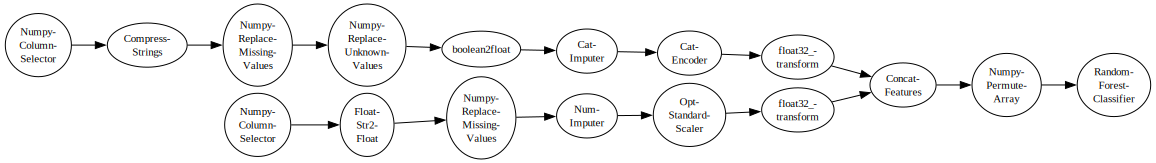

In [35]:
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.

### Reading training data

In [ ]:
train_df = pipeline_optimizer.get_data_connections()[0].read()

train_X = train_df.drop(['Risk'], axis=1).values
train_y = train_df.Risk.values

### Test pipeline model locally

In [37]:
predicted_y = best_pipeline.predict(train_X)
predicted_y[:5]

array(['No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk'], dtype=object)

Define `fairness_info` for `disparate_impact` scorer.

In [40]:
fairness_info_lale = {
            "protected_attributes": [
                {"feature": train_df.columns.get_loc("Sex"), "reference_group": ['male']},
                {"feature": train_df.columns.get_loc("Age"), "reference_group": [[20,40], [60,90]]}
            ],
            "favorable_labels": ["No Risk"]}

In [41]:
from lale.lib.aif360 import disparate_impact
from sklearn.metrics import accuracy_score

disparate_impact_scorer = disparate_impact(**fairness_info_lale)
print("Accuracy: ", accuracy_score(y_true= train_y, y_pred=predicted_y))
print("Disparate impact: ", disparate_impact_scorer(best_pipeline, train_X, train_y))

Accuracy:  0.93014853472501
Disparate impact:  0.6918131000032457


## Bias mitigation: optimizer configuration

Provide input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

Define `fairness_info`:

 - protected_attribute_names (array of items : string) – Subset of feature names for which fairness is desired.

 - favorable_labels (array of union) – Label values which are considered favorable (i.e. “positive”). Available types
        string
            Literal value
        number
            Numerical value
        array of number, >= 2 items, <= 2 items
            Numeric range [a,b] from a to b inclusive.

In [46]:
fairness_info_mitigation = {
            "protected_attributes": [
                {"feature": "Sex", "reference_group": ['male'], "monitored_group": ['female']}
            ],
            "favorable_labels": ["No Risk"]}

In [47]:
experiment_mitigation = AutoAI(credentials, space_id=space_id)

pipeline_optimizer_mitigation = experiment_mitigation.optimizer(
    name='Credit Risk Prediction and bias mitigation - AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring="accuracy_and_disparate_impact",
    fairness_info=fairness_info_mitigation,
    max_number_of_estimators = 4
)

Configuration parameters can be retrieved via `get_params()`.

In [48]:
pipeline_optimizer_mitigation.get_params()

{'name': 'Credit Risk Prediction and bias mitigation - AutoAI',
 'desc': '',
 'prediction_type': 'binary',
 'prediction_column': 'Risk',
 'prediction_columns': None,
 'timestamp_column_name': None,
 'scoring': 'accuracy_and_disparate_impact',
 'holdout_size': None,
 'max_num_daub_ensembles': 4,
 't_shirt_size': 'm',
 'train_sample_rows_test_size': None,
 'include_only_estimators': None,
 'include_batched_ensemble_estimators': None,
 'backtest_num': None,
 'lookback_window': None,
 'forecast_window': None,
 'backtest_gap_length': None,
 'cognito_transform_names': None,
 'csv_separator': ',',
 'excel_sheet': None,
 'encoding': 'utf-8',
 'positive_label': None,
 'drop_duplicates': True,
 'outliers_columns': None,
 'text_processing': None,
 'word2vec_feature_number': None,
 'daub_give_priority_to_runtime': None,
 'text_columns_names': None,
 'sampling_type': None,
 'sample_size_limit': None,
 'sample_rows_limit': None,
 'sample_percentage_limit': None,
 'number_of_batch_rows': None,
 'n_pa

<a id="run_mit"></a>
## Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [49]:
run_details_mitigation = pipeline_optimizer_mitigation.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job 27d691cc-a25e-4ac7-b674-cac7671f9e4a completed: 100%|████████| [08:09<00:00,  4.90s/it]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [50]:
pipeline_optimizer_mitigation.get_run_status()

'completed'

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [51]:
pipeline_optimizer_mitigation.summary()

,Enhancements,Estimator,training_accuracy_and_disparate_impact_(optimized),training_disparate_impact_Sex,training_roc_auc,holdout_average_precision,holdout_log_loss,holdout_roc_auc,training_balanced_accuracy,training_f1,...,training_average_precision,training_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,training_accuracy,holdout_disparate_impact
Pipeline Name,,,,,,,,,,,,,,,,,,,,,
Pipeline_19,"HPO, FE, HPO, Ensemble",BatchedTreeEnsembleClassifier(ExtraTreesClassi...,0.893827,1.011278,0.841266,0.665331,2.220446e-16,0.857505,0.745586,0.857013,...,0.906313,0.471109,1.000000,0.812351,1.000000,1.000000,0.907043,1.000000,0.798794,1.096222
Pipeline_18,"HPO, FE, HPO",ExtraTreesClassifier,0.893827,1.011278,0.841266,0.665331,2.220446e-16,0.857505,0.745586,0.857013,...,0.906313,0.471109,1.000000,0.812351,1.000000,1.000000,0.907043,1.000000,0.798794,1.096222
Pipeline_17,"HPO, FE",ExtraTreesClassifier,0.893827,1.011278,0.841266,0.665331,2.220446e-16,0.857505,0.745586,0.857013,...,0.906313,0.471109,1.000000,0.812351,1.000000,1.000000,0.907043,1.000000,0.798794,1.096222
Pipeline_16,HPO,ExtraTreesClassifier,0.885445,1.009681,0.829976,0.665331,2.220446e-16,0.848983,0.730185,0.842635,...,0.899676,0.511403,1.000000,0.805573,1.000000,1.000000,0.883551,1.000000,0.780728,1.096222
Pipeline_15,,ExtraTreesClassifier,0.885445,1.009681,0.829976,0.665331,2.220446e-16,0.848983,0.730185,0.842635,...,0.899676,0.511403,1.000000,0.805573,1.000000,1.000000,0.883551,1.000000,0.780728,1.096222
Pipeline_2,HPO,XGBClassifier,0.889312,1.008463,0.843840,0.462943,3.303090e-01,0.840235,0.740480,0.846126,...,0.911090,0.447442,0.948795,0.813743,0.861723,0.818709,0.881535,0.901288,0.786973,0.976996
Pipeline_1,,XGBClassifier,0.889312,1.008463,0.843840,0.462943,3.303090e-01,0.840235,0.740480,0.846126,...,0.911090,0.447442,0.948795,0.813743,0.861723,0.818709,0.881535,0.901288,0.786973,0.976996
Pipeline_5,"HPO, FE, HPO, Ensemble",BatchedTreeEnsembleClassifier(XGBClassifier),0.895693,0.998487,0.846692,0.462485,3.259183e-01,0.846007,0.748863,0.854718,...,0.911919,0.440425,0.966867,0.817006,0.867735,0.818763,0.896304,0.906780,0.797456,0.951047
Pipeline_4,"HPO, FE, HPO",XGBClassifier,0.895693,0.998487,0.846692,0.462485,3.259183e-01,0.846007,0.748863,0.854718,...,0.911919,0.440425,0.966867,0.817006,0.867735,0.818763,0.896304,0.906780,0.797456,0.951047


In [53]:
best_pipeline_mitigation = pipeline_optimizer_mitigation.get_pipeline()

### Visualize pipeline

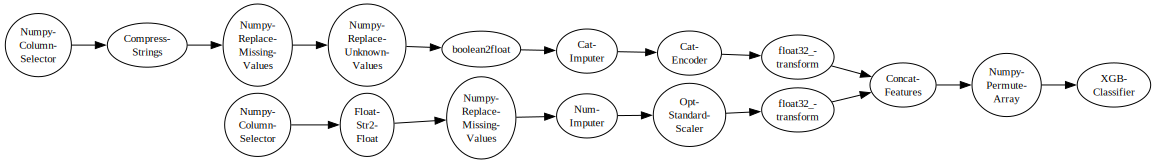

In [54]:
best_pipeline_mitigation.visualize()

### Reading training data

In [ ]:
train_df = pipeline_optimizer_mitigation.get_data_connections()[0].read()

train_X = train_df.drop(['Risk'], axis=1).values
train_y = train_df.Risk.values

### Test pipeline model locally

In [56]:
predicted_y = best_pipeline_mitigation.predict(train_X)
predicted_y[:5]

array(['No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk'], dtype=object)

Define `fairness_info` for `disparate_impact` and `accuracy_and_disparate_impact` scorers.

In [59]:
fairness_info_mitigation_lale = {
            "protected_attributes": [
                {"feature": train_df.columns.get_loc("Sex"), "reference_group": ['male']}
            ],
            "favorable_labels": ["No Risk"]}

In [60]:
from lale.lib.aif360 import disparate_impact, accuracy_and_disparate_impact
from sklearn.metrics import accuracy_score

disparate_impact_scorer = disparate_impact(**fairness_info_mitigation_lale)
accuracy_and_disparate_impact_scorer = accuracy_and_disparate_impact(**fairness_info_mitigation_lale)
print("Accuracy: ", accuracy_score(y_true= train_y, y_pred=predicted_y))
print("Accuracy and disparate impact: ", accuracy_and_disparate_impact_scorer(best_pipeline, train_X, train_y))
print("Disparate impact: ", disparate_impact_scorer(best_pipeline, train_X, train_y))

Accuracy:  0.8514652749899638
Accuracy and disparate impact:  0.9138764646804844
Disparate impact:  1.1140765419331191


<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

In [61]:
pipeline_name = "Pipeline_1"

### Deployment creation

In [62]:
from ibm_watsonx_ai.deployment import WebService

service = WebService(credentials, source_space_id=space_id)

service.create(
    experiment_run_id=training_id,
    model=pipeline_name, 
    deployment_name="Credit Risk Deployment AutoAI - bias detection")

Preparing an AutoAI Deployment...
Published model uid: d1248288-9342-4e48-afe2-0c4206a5689a
Deploying model d1248288-9342-4e48-afe2-0c4206a5689a using V4 client.


######################################################################################

Synchronous deployment creation for id: 'd1248288-9342-4e48-afe2-0c4206a5689a' started

######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
....
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='1ca08ed4-5baa-4809-b75e-f9b90c385f1d'
-----------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [ ]:
print(service)

To show all available information about deployment use `.get_params()` method:

In [ ]:
service.get_params()

### Scoring of webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [65]:
predictions = service.score(payload=train_df.drop(['Risk'], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.7488465366140008, 0.2511534633859992]],
    ['No Risk', [0.835607245080173, 0.164392754919827]],
    ['No Risk', [0.9057868200726807, 0.09421317992731928]],
    ['No Risk', [0.7172061939164995, 0.2827938060835004]],
    ['Risk', [0.30902094006538394, 0.6909790599346161]],
    ['Risk', [0.06607430398464198, 0.933925696015358]],
    ['No Risk', [0.6907337888795883, 0.30926621112041175]],
    ['No Risk', [0.7780959460139274, 0.22190405398607255]],
    ['No Risk', [0.8370824388740584, 0.16291756112594158]],
    ['Risk', [0.06607430398464198, 0.933925696015358]]]}]}

If you want to work with the webservice in external Python application you can retrieve the service object by:
 - initialize service by `service = WebService(credentials)`
 - get deployment_id by `service.list()` method
 - get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

### Deleting deployment
You can delete exeiting deployment by calling `service.delete()` command.
To list existing web services you can use `service.list()`.

<a id="cleanup"></a>
## Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## Summary and next steps

You successfully completed this notebook!.
 
You learned how to use `ibm-watsonx-ai` to run AutoAI experiments. 
 
Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts.  

### Authors

**Dorota Dydo-Rożniecka**, Intern in Watson Machine Learning at IBM.

**Szymon Kucharczyk**, Software Engineer in Watson Machine Learning at IBM.

Copyright © 2023-2025 IBM. This notebook and its source code are released under the terms of the MIT License.